In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
url = 'https://raw.githubusercontent.com/AmbujaBudakoti27/Sarcasm-Detection/main/sarcasm_detection_shared_task_twitter_training.jsonl'
df=pd.read_json(url,lines=True)

In [3]:
df.head()

,label,response,context
0,SARCASM,@USER @USER @USER I don't get this .. obviousl...,[A minor child deserves privacy and should be ...
1,SARCASM,@USER @USER trying to protest about . Talking ...,[@USER @USER Why is he a loser ? He's just a P...
2,SARCASM,@USER @USER @USER He makes an insane about of ...,[Donald J . Trump is guilty as charged . The e...
3,SARCASM,@USER @USER Meanwhile Trump won't even release...,[Jamie Raskin tanked Doug Collins . Collins lo...
4,SARCASM,@USER @USER Pretty Sure the Anti-Lincoln Crowd...,[Man ... y ’ all gone “ both sides ” the apoca...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     5000 non-null   object
 1   response  5000 non-null   object
 2   context   5000 non-null   object
dtypes: object(3)
memory usage: 117.3+ KB


In [5]:
df['label'].value_counts()

NOT_SARCASM    2500
SARCASM        2500
Name: label, dtype: int64

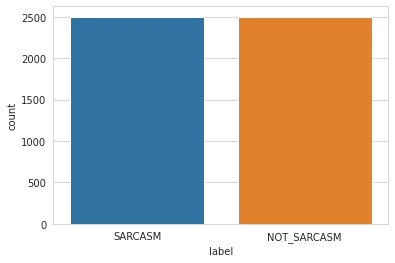

In [6]:
sns.set_style('whitegrid')
sns.countplot(x='label',data=df)

In [7]:
df['response']=df['response'].str.replace('@USER', "") 
df['response']=df['response'].str.replace('\d+', '')
df['response']=df['response'].str.lower()
df['response']=df['response'].str.replace('[^\w\s]','')

df['context']=df['context'].apply(lambda x: ','.join(map(str, x)))
df['context']=df['context'].str.replace('@USER', "") 
df['context']=df['context'].str.lower()
df['context']=df['context'].str.replace('[^\w\s]','')
df['context']=df['context'].str.replace('\d+', '')

df.head()

,label,response,context
0,SARCASM,i dont get this obviously you do care or y...,a minor child deserves privacy and should be k...
1,SARCASM,trying to protest about talking about him a...,why is he a loser hes just a press secretar...
2,SARCASM,he makes an insane about of money from the ...,donald j trump is guilty as charged the evid...
3,SARCASM,meanwhile trump wont even release his sat sc...,jamie raskin tanked doug collins collins look...
4,SARCASM,pretty sure the antilincoln crowd claimed th...,man y all gone both sides the apocalypse o...


In [8]:
X=df['response'].values
y=df['label'].values

In [9]:
y = pd.get_dummies(df['label'])
y = y.iloc[:,1].values
y

array([1, 1, 1, ..., 0, 0, 0], dtype=uint8)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [11]:
vocab_size=10000
embedding_dim=16
max_length=32
trunc_type='post'
padding_type='post'
oov_tok='<oov>'

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer= Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index=tokenizer.word_index

training_sequences=tokenizer.texts_to_sequences(X_train)
training_padded=pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences=tokenizer.texts_to_sequences(X_test)
testing_padded=pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [13]:
training_padded

array([[  89, 3205,   22, ...,    0,    0,    0],
       [  26, 2422,    8, ...,    0,    0,    0],
       [   2, 4930,  209, ...,    0,    0,    0],
       ...,
       [ 529,  246,   84, ...,    0,    0,    0],
       [  25,  315,    9, ...,    0,    0,    0],
       [ 984,   19,   84, ...,    0,    0,    0]], dtype=int32)

In [14]:
print(training_padded.shape)
print(testing_padded.shape)

(4000, 32)
(1000, 32)


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten

In [16]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Flatten())

model.add(Dense(units=32,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=10,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1,activation='sigmoid'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 16)            160000    
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                16416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [17]:
model.fit(x=training_padded, y=y_train, batch_size=256, epochs=100, validation_data=(testing_padded, y_test), verbose=1)

Epoch 1/100
16/16 [==============================] - 2s 20ms/step - loss: 0.6929 - accuracy: 0.4947 - val_loss: 0.6916 - val_accuracy: 0.5200
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6919 - accuracy: 0.5098 - val_loss: 0.6913 - val_accuracy: 0.5250
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6915 - accuracy: 0.5080 - val_loss: 0.6912 - val_accuracy: 0.5320
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6910 - accuracy: 0.5102 - val_loss: 0.6910 - val_accuracy: 0.5400
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6907 - accuracy: 0.5190 - val_loss: 0.6908 - val_accuracy: 0.5310
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6905 - accuracy: 0.5245 - val_loss: 0.6906 - val_accuracy: 0.5450
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.6900 - accuracy: 0.5213 - val_loss: 0.6904 - val_accuracy: 0.5470
Epoch 8/100

In [18]:
df_m=pd.DataFrame(model.history.history)
df_m['Epoch']=range(1,101)
df_m.index=df_m['Epoch']
df_m

,loss,accuracy,val_loss,val_accuracy,Epoch
Epoch,,,,,
1,0.692903,0.49475,0.691627,0.520,1
2,0.691915,0.50975,0.691334,0.525,2
3,0.691536,0.50800,0.691161,0.532,3
4,0.691025,0.51025,0.690987,0.540,4
5,0.690722,0.51900,0.690769,0.531,5
...,...,...,...,...,...
96,0.254539,0.96475,0.608375,0.695,96
97,0.245581,0.96975,0.609137,0.698,97
98,0.240730,0.96875,0.612534,0.701,98


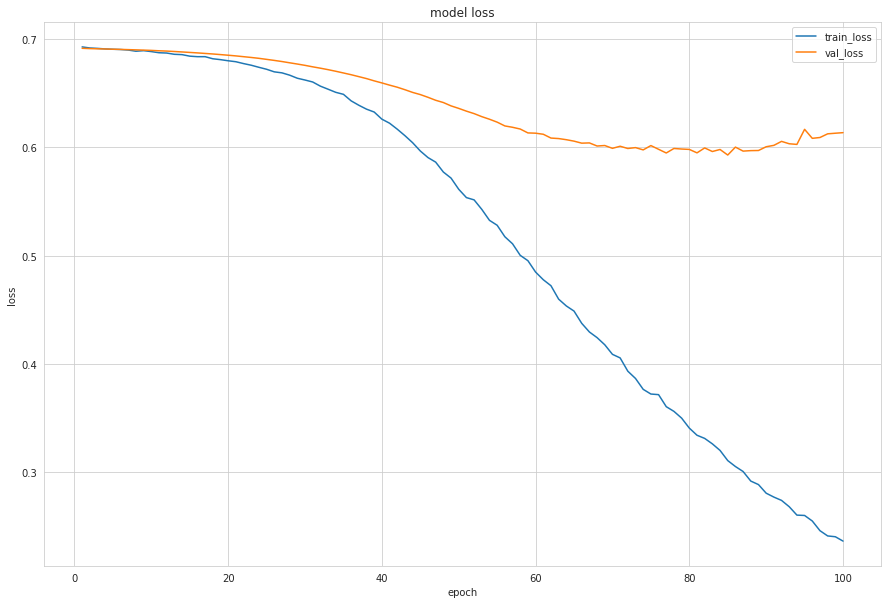

In [19]:
#Loss Graph(Training and Validation)
fig= plt.figure(figsize=(15,10))
plt.plot(df_m['loss'])
plt.plot(df_m['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

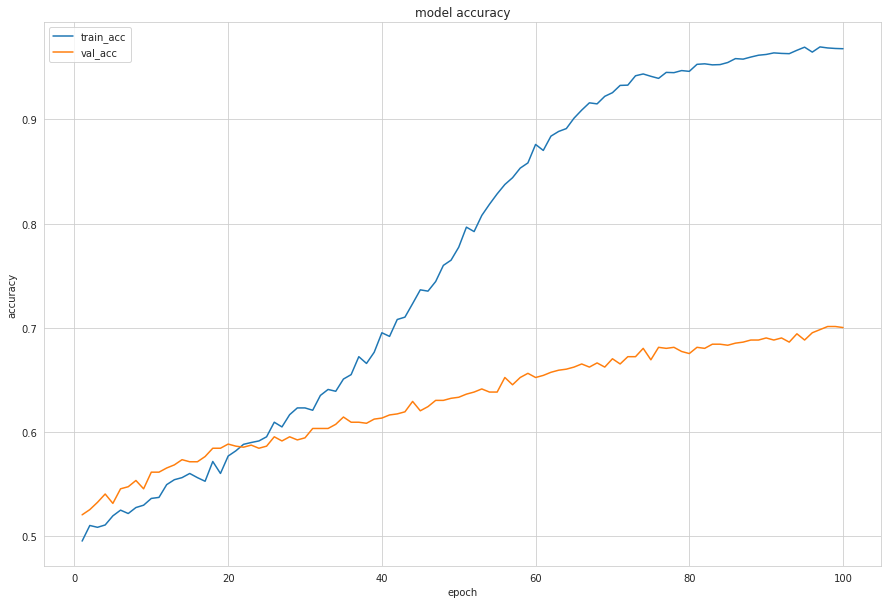

In [20]:
fig= plt.figure(figsize=(15,10))
plt.plot(df_m['accuracy'])
plt.plot(df_m['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'])
plt.show()